# Modelo estocástico para población de ganado vacuno de engorde

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import json
from tqdm import tqdm_notebook as tqdm

## Parámetros 

### Para variables normalmente distribuidas

<span style="color:red"> *muMsex, sigmaMsex:* </span>
media y desviación estándar del tiempo de madures sexual medido en meses

<span style="color:red"> *muTep, sigmaTep:* </span>
media y desviación estándar del tiempo del tiempo entre partos de una vaca

<span style="color:red"> *muNp, sigmaNp:* </span>
media y desviación estándar del tiempo del número de partos de una vaca. 
Se redondea a un numero entero no negativo

### Para variables multinomiales
<span style="color:red"> *pHf*  </span>: probabilidad de nacer hembra fértil

<span style="color:red"> *pM*  </span>: probabilidad de nacer macho

<span style="color:red"> *pHe*  </span>: probabilidad de nacer hembra estéril

In [2]:
muMsex, sigmaMsex = 24, 0.5
muTep, sigmaTep = 12, 0.75
#muNp, sigmaNp = 8, 0.10
pHf, pM, pHe = 0.400, 0.5, 0.1
numP = 8  #número de partos de una vaca. Por ahora deterministico. 

In [3]:
def desc(x):
    '''
    Input x:   es la fecha de nacimieto de una vaca fértil. 
    Output: [x,H, M, E] con H, M, E listas de fechas de nacimiento de 
    decendientes hembras fertiles, terneros y hembras estériles  
    respecitvamente de la vaca nacida en la fecha x
    '''
    #numP = int(np.random.normal(muNp, sigmaNp))
    mS = np.random.normal(muMsex, sigmaMsex)
    z = np.random.normal(muTep, sigmaTep,numP)
    sex = np.random.multinomial(n = 1, pvals=[pHf, pM, pHe], size = numP).tolist()
    z = mS+np.cumsum(z)+x
    #mi, ma = z[0], z[-1]
    Ht =  [ [z[i], sex[i]] for i in range(numP)]
    hf = [ ht[0] for ht in Ht if ht[1]==[1, 0, 0]]
    ma = [ ht[0] for ht in Ht if ht[1]==[0, 1, 0]]
    he = [ ht[0] for ht in Ht if ht[1]==[0, 0, 1]]
    return [x,hf, ma, he]


In [4]:
def nuevaG(HHt):
    '''
    Input HHt: lista con   datos  del tipo [x,H, M,E]. 
    Output: lista  con datos del tipo [x,H,M,E] decendientes de las hembras 
    en HHt  
    '''
    H = list(it.chain.from_iterable([w[1] for w in HHt]))
    return [desc(h) for h in H]

In [5]:
#sex = np.random.binomial(n = 1, p=2*pHf , size = 1).tolist()[0] 
#if sex == 0: return [x, [], [],[x]]

In [6]:
def hatoHistorico(t):
    '''
    Input t: tiempo en meses . 
    Output: lista  con datos del tipo [x,H, M, E] de decendientes hasta el tiempo t 
    de una hembra inicial eva
    '''
    eva = -24
    sex = np.random.binomial(n = 1, p=2*pHf , size = 1).tolist()[0] 
    if sex == 0: return [[eva, [], [],[eva]]]
    else: 
        G = [desc(eva)]
        HH = [] 
        tt = 0
        while (tt <t):
            HH = list(it.chain.from_iterable([HH,G]))
            G = nuevaG(G)
            if len(G)==0: break
            else: tt = min([z[0] for z in G])
        return [hh for hh in HH if hh[0]< t]

## Simulaciones

In [8]:
# Para los gráficos
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 30,
        }

In [9]:
# Numero de vacas con que se inicia el hato
hato_inic = 200

### Simulación de nacimientos

In [10]:
def nacimientos(s,HH):
    '''
    Input s: tiempo en meses. HH: hato formado por listas con datos [x, H, M,E]
    Output: lista de fechas de nacimiento del hato HH que hayan nacido antes del tiempo s
    '''
    Nh = [h[0] for h in HH ]
    M = [h[2] for h in HH]
    E = [h[3] for h in HH]
    Nm = list(it.chain.from_iterable(M))
    Ne = list(it.chain.from_iterable(E))
    NHH = list(it.chain.from_iterable([Nh,Nm, Ne]))
    return [x for x in NHH if 0<x< s]

In [11]:
def simuNacimientos():
    s = 120
    N = []
    for i in tqdm(range(hato_inic)):
        HH = hatoHistorico(s)
        N = list(it.chain.from_iterable([nacimientos(s,HH),N]))
    return N

In [12]:
partos = simuNacimientos()

In [59]:
len(partos)

3351

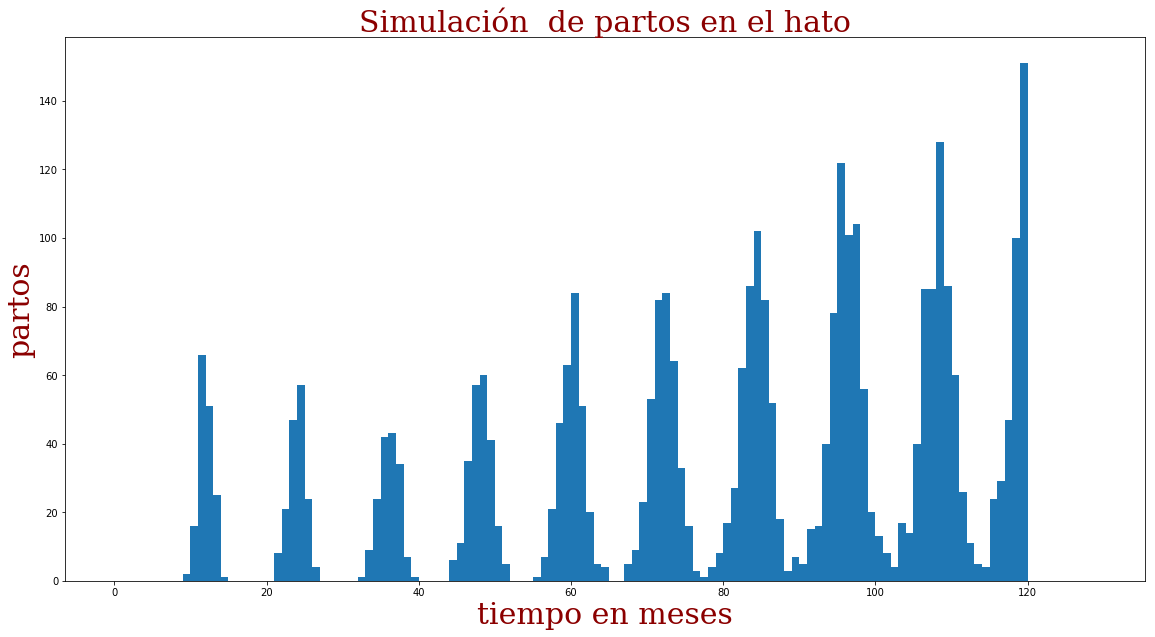

In [60]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.hist(partos,np.array(range(130)))
plt.xlabel('tiempo en meses', fontdict=font)
plt.ylabel('partos', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.title("Simulación  de partos en el hato", fontdict=font)
plt.savefig('partos.pdf')
plt.show()

### Simulación de terneros de 24 meses

In [14]:
def terneros(s,HH):
    '''
    Input s: tiempo en meses. HH: hato formado por listas del tipo [x, H, M, E]
    Output: lista de fechas de nacimiento de terneros nacidos antes de la fecha s 
    '''
    M = [h[2] for h in HH]
    Nm = list(it.chain.from_iterable(M))
    return [x + 24 for x in Nm if 0 < x+24< s]

In [15]:
def simuTerneros():
    s = 120
    N = []
    for i in tqdm(range(hato_inic)):
        HH = hatoHistorico(s)
        N = list(it.chain.from_iterable([terneros(s,HH),N]))
    return N

In [16]:
ventaT = simuTerneros()

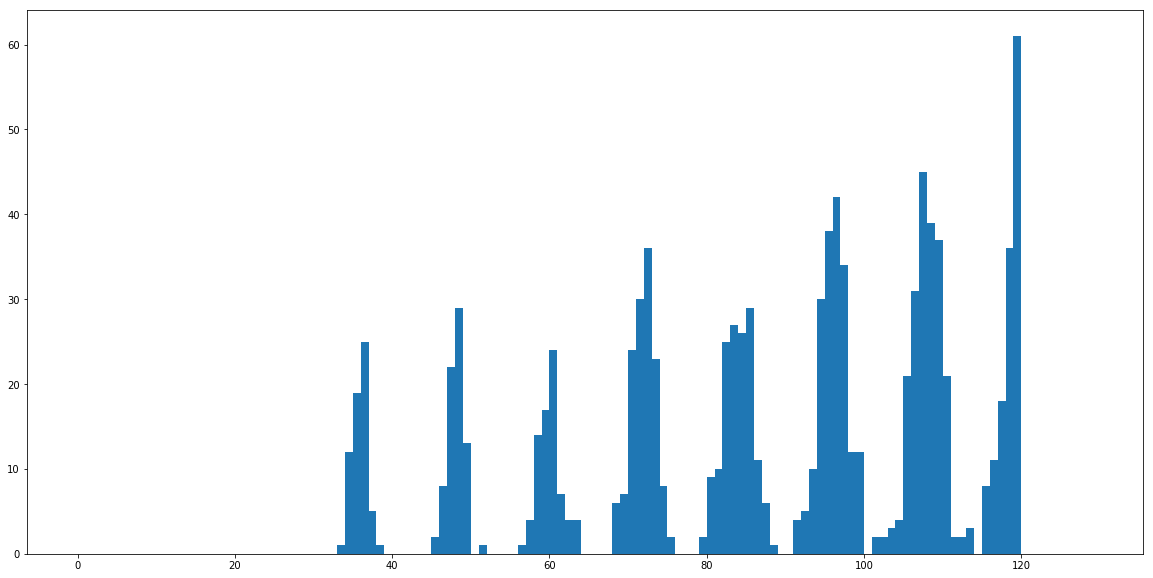

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.hist(ventaT,np.array(range(130)))
plt.show()

### Simulación de hembras estériles

In [18]:
def esteriles(s,HH):
    '''
    Input s: tiempo en meses. HH: hato formado por listas del tipo [x,[H, M]]
    Output: lista de fechas de nacimiento de terneros nacidos antes de la fecha s 
    '''
    M = [h[3] for h in HH]
    Nm = list(it.chain.from_iterable(M))
    return [x + 36 for x in Nm if 0 < x+36< s]

In [19]:
def simuEsteriles():
    s = 120
    N = []
    for i in tqdm(range(hato_inic)):
        HH = hatoHistorico(s)
        N = list(it.chain.from_iterable([esteriles(s,HH),N]))
    return N

In [20]:
ventaE = simuEsteriles()

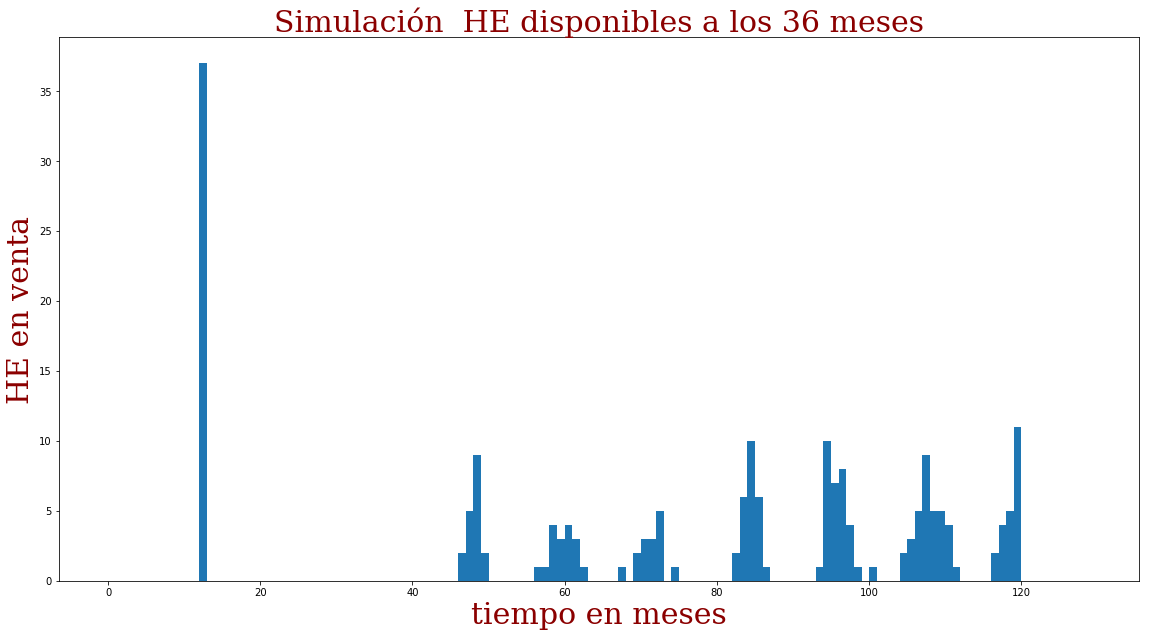

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.hist(ventaE,np.array(range(130)))
plt.xlabel('tiempo en meses', fontdict=font)
plt.ylabel('HE en venta', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.title("Simulación  HE disponibles a los 36 meses", fontdict=font)
#plt.savefig('hato.pdf')
plt.show()

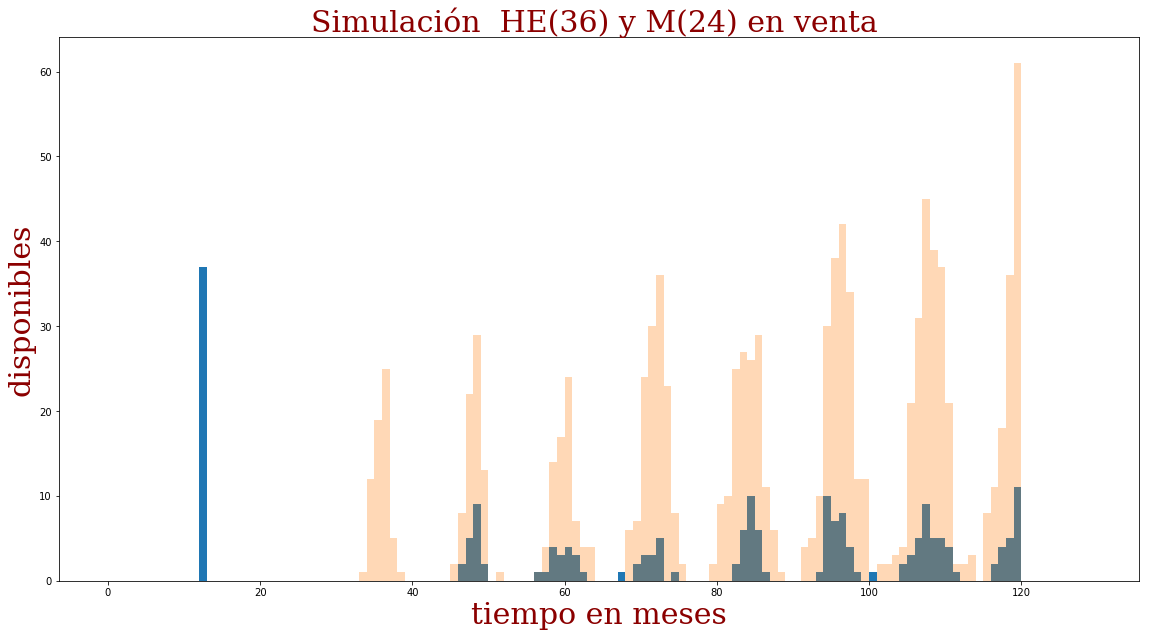

In [61]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.hist(ventaE,np.array(range(130)))
ax.hist(ventaT,np.array(range(130)), alpha = 0.3)
plt.xlabel('tiempo en meses', fontdict=font)
plt.ylabel('disponibles', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.title("Simulación  HE(36) y M(24) en venta ", fontdict=font)
plt.savefig('venta.pdf')
plt.show()

In [38]:
def fRetiro(hht):
    '''
    Input hht: dato  del tipo [x,H,M,E] que da la los 
    decendientes terneras y terneros respecitvamente de la vaca fértil nacida
    en la fecha x
    Output: real positivo que da el mes en que la vaca nacida en el mes x es retirada 
    del hato por vejez
    '''
    return max(list(it.chain.from_iterable([hht[1],hht[2], hht[3]])))
     

In [51]:
def simuRetiros():
    s = 120
    muestra = []
    for i in tqdm(range(hato_inic)):
        HH = hatoHistorico(s)
        if len(HH)>1:  
            hv = [fRetiro(hh)+12  for hh in HH]
            muestra = list(it.chain.from_iterable([hv,muestra]))
    return np.sort(muestra)

In [56]:
vacasviejas = simuRetiros()

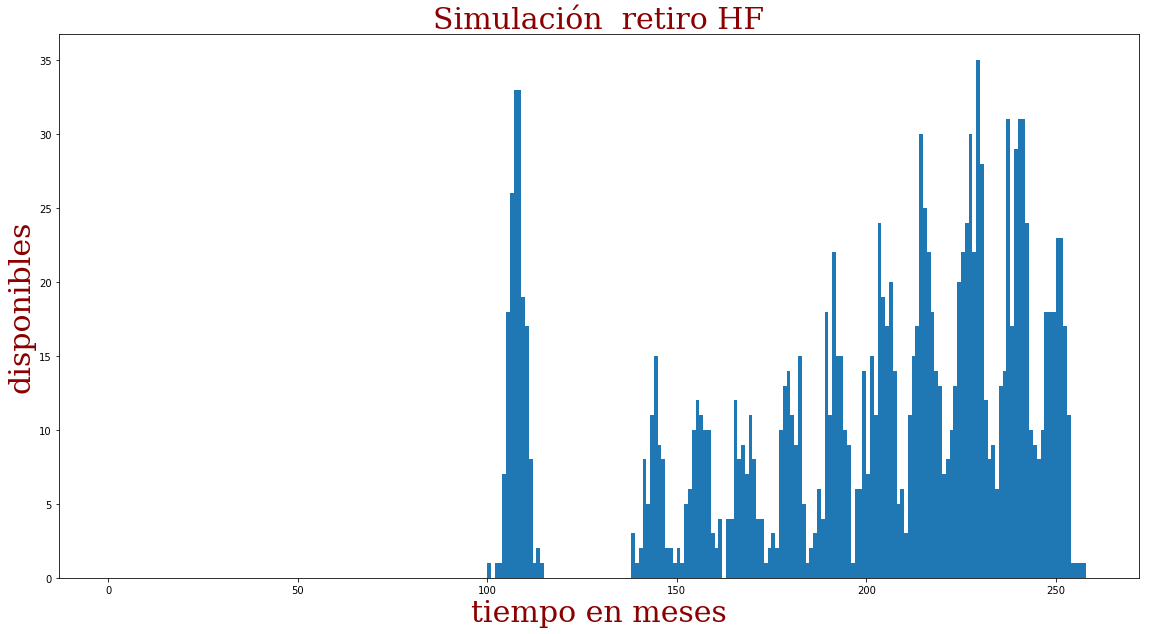

In [62]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.hist(vacasviejas,np.array(range(260)))
#ax.hist(ventaT,np.array(range(130)), alpha = 0.3)
plt.xlabel('tiempo en meses', fontdict=font)
plt.ylabel('disponibles', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.title("Simulación  retiro HF", fontdict=font)
plt.savefig('vacasviejas.pdf')
plt.show()

### Simulación del factor de  crecimiento del hato de hembras

In [39]:
def simulHfactor(s):
    muestra = []
    for i in tqdm(range(hato_inic)):
        HH = hatoHistorico(s)
        if len(HH)==1: muestra.append(len(HH))
        else:
            HH = [hh for hh in HH if (hh[0]< s) & (fRetiro(hh)>s)]
            muestra.append(len(HH))
    return muestra    



In [42]:
muestra = simulHfactor(120)
(np.mean(muestra), np.std(muestra))

(6.265, 4.783803403151095)

### Simulación de la población de hembras fértiles

In [43]:
poblacion = [np.mean(simulHfactor(s)) for s in tqdm(range(120))]

In [64]:
ejex = range(120)
x = ejex[10:]
y = np.log(poblacion[10:]) 
alf, beta = np.polyfit(x, y, 1)
curva = np.exp(alf*np.array(ejex))*np.exp(beta)
dup = np.log(2)/alf
(alf, beta, dup)

(0.015904585228399104, 0.01388161810922674, 43.581594276489966)

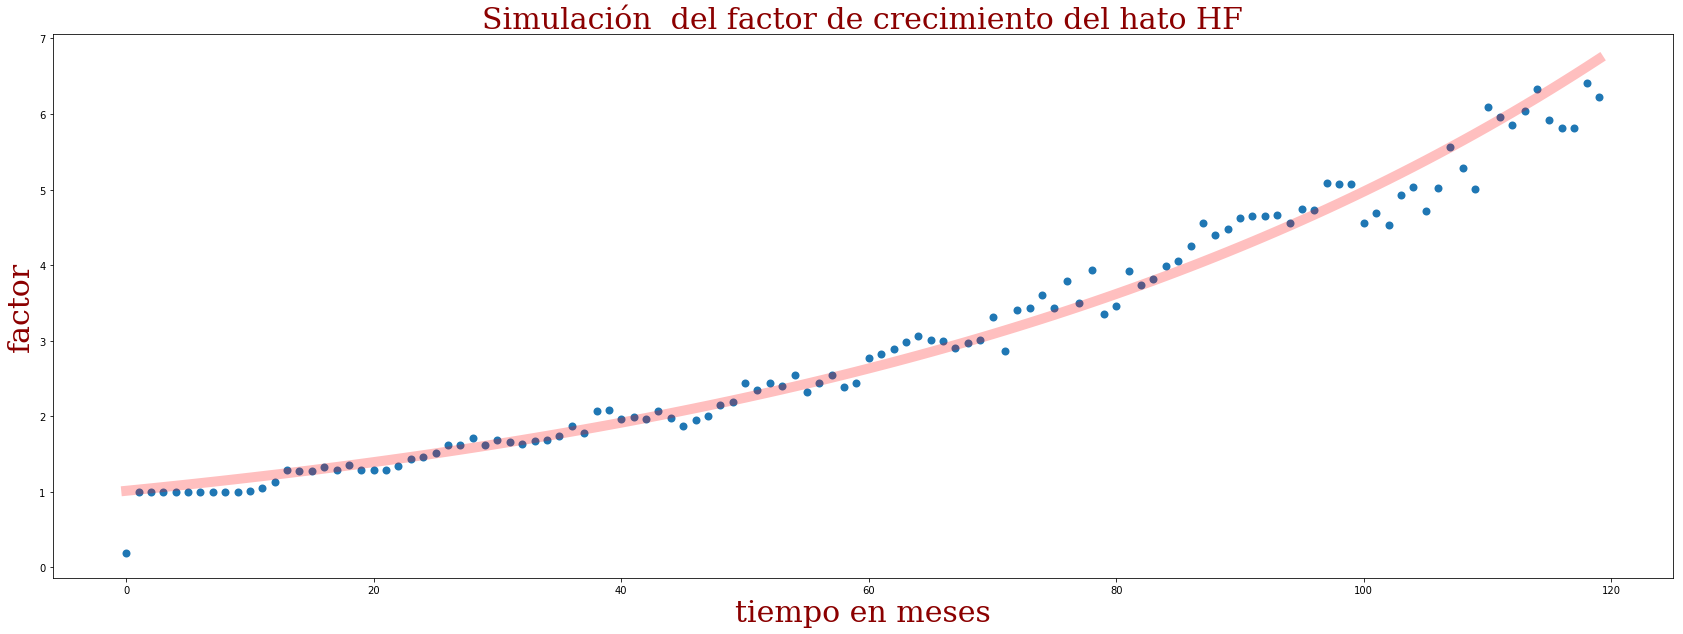

In [63]:
ejex = range(120)
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
ax.scatter(ejex, poblacion, lw = 2 )
ax.plot(ejex, curva,color='red', alpha = 0.25, linewidth= 10.0 )
#ax.scatter(ejex, ejem, lw = 2 )
plt.xlabel('tiempo en meses', fontdict=font)
plt.ylabel('factor', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.title("Simulación  del factor de crecimiento del hato HF", fontdict=font)
plt.savefig('hato.pdf')
plt.show()

### Simulación de riesgo

In [ ]:
#with open('read2.json', 'w') as outfile:
    #json.dump(HH, outfile, sort_keys=True, indent=4)

In [46]:
def simulRiesgo(s):
    muestra = []
    for i in tqdm(range(50)):
        d = np.mean(simulHfactor(s))
        muestra.append(d)
    return [np.mean(muestra), np.std(muestra)]


In [47]:
simulRiesgo(120)

[6.847600000000001, 0.2655489408753121]

def hato(t):
    hv = [[hh[0], fRetiro(hh)] for hh in HH if (hh[0]<t) & (fRetiro(hh)>t)]
    mm = list(it.chain.from_iterable([hh[2] for hh in HH]))
    mv = [ m for m in mm if (m <t) & (m+24>t)]
    return [hv, mv]

def EdadHato(t):
    hv = [t-hh[0] for hh in HH if (hh[0]<t) & (fRetiro(hh)>t)]
    mm = list(it.chain.from_iterable([hh[1] for hh in HH]))
    mv = [ t-m for m in mm if (m <t) & (m+24>t)]
    return [hv, mv]